## Experiment to Detect and Segment Stigmas
I would want to detect and stigmas and then classify or calc percentage of white to orange ratio

#### Methods to explore:
Each of these methods brings a unique approach to segmentation:
- **K-means Clustering**: Groups colors without needing manual thresholds.
- **Edge Detection + Color Mask**: Combines edges and colors to improve separation.
- **LBP**: Focuses on texture for feature detection.
- **SLIC Superpixel Segmentation**: Creates homogeneous regions based on color and texture.
- **Histogram-based Thresholding**: Adapts to lighting changes for threshold-based segmentation.

Get the data and plot sample

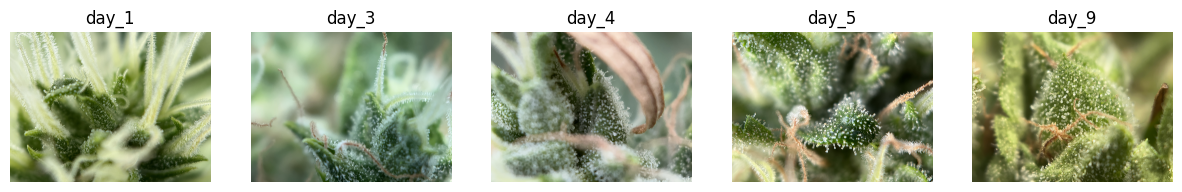

In [1]:
import os
from PIL import Image
import matplotlib.pyplot as plt

# Path to the dataset
dataset_path = "/sise/shanigu-group/etaylor/assessing_cannabis_exp/images/stigmas_images"

# Shooting days to sample from
shoot_days = ["day_1", "day_3", "day_4", "day_5", "day_9"]

# Load a sample image from each day
sample_images = []
for day in shoot_days:
    day_path = os.path.join(dataset_path, day)
    # Get the list of images and select the first one as a sample
    images = os.listdir(day_path)
    if images:
        image_path = os.path.join(day_path, images[0])
        image = Image.open(image_path)
        sample_images.append((day, image))

# Plotting the sample images
plt.figure(figsize=(15, 10))
for i, (day, img) in enumerate(sample_images):
    plt.subplot(1, len(sample_images), i + 1)
    plt.imshow(img)
    plt.title(day)
    plt.axis("off")

plt.show()


#### Functions to apply the methods offered

In [20]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.feature import local_binary_pattern
from skimage.segmentation import slic
from skimage.color import label2rgb


def extract_and_display_stigmas(image_path):
    """
    Function to extract and display white-green and orange stigmas from a cannabis flower image.

    Args:
        image_path (str): Path to the image file.
    """
    # Load the image
    image = cv2.imread(image_path)
    if image is None:
        print("Error: Unable to load image. Check the file path.")
        return

    # Convert to HSV and proceed with processing if the image is loaded
    hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    # Adjusted HSV ranges for white-green and orange stigmas
    # Attempting to include a wider range of light tones
    white_green_lower = np.array(
        [30, 10, 100], np.uint8
    )  # Lower saturation and brightness for lighter tones
    white_green_upper = np.array([85, 150, 255], np.uint8)

    orange_lower = np.array([5, 50, 100], np.uint8)  # Allowing darker tones of orange
    orange_upper = np.array([25, 255, 255], np.uint8)

    # Threshold the image to get white-green and orange regions
    mask_white_green = cv2.inRange(hsv_image, white_green_lower, white_green_upper)
    mask_orange = cv2.inRange(hsv_image, orange_lower, orange_upper)

    # Apply morphological operations to clean up the masks
    kernel = np.ones((5, 5), np.uint8)
    mask_white_green = cv2.morphologyEx(mask_white_green, cv2.MORPH_CLOSE, kernel)
    mask_orange = cv2.morphologyEx(mask_orange, cv2.MORPH_CLOSE, kernel)

    # Extract white-green and orange parts of the image
    result_white_green = cv2.bitwise_and(image, image, mask=mask_white_green)
    result_orange = cv2.bitwise_and(image, image, mask=mask_orange)

    # Display the results
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1)
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title("Original Image")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.imshow(cv2.cvtColor(result_white_green, cv2.COLOR_BGR2RGB))
    plt.title("White-Green Stigmas")
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.imshow(cv2.cvtColor(result_orange, cv2.COLOR_BGR2RGB))
    plt.title("Orange Stigmas")
    plt.axis("off")

    plt.show()


def edge_detection_with_color(image_path):
    # Load the image
    image = cv2.imread(image_path)
    if image is None:
        print("Error: Unable to load image. Check the file path.")
        return
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    edges = cv2.Canny(gray_image, threshold1=100, threshold2=200)

    # Combine with color segmentation
    hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    lower_white_green = np.array([30, 10, 100], np.uint8)
    upper_white_green = np.array([85, 150, 255], np.uint8)
    mask = cv2.inRange(hsv_image, lower_white_green, upper_white_green)
    result = cv2.bitwise_and(edges, edges, mask=mask)

    plt.imshow(result, cmap="gray")
    plt.title("Edge Detection with Color Mask")
    plt.axis("off")
    plt.show()


def segment_using_kmeans(image_path, k=3):
    # Load the image and resize for faster processing
    image = cv2.imread(image_path)
    resized_image = cv2.resize(image, (0, 0), fx=0.5, fy=0.5)

    # Reshape the image to a 2D array of pixels and 3 color values (RGB)
    pixel_values = resized_image.reshape((-1, 3))
    pixel_values = np.float32(pixel_values)

    # Define criteria and apply KMeans clustering
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.2)
    _, labels, centers = cv2.kmeans(
        pixel_values, k, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS
    )

    # Convert back to 8-bit values
    centers = np.uint8(centers)
    segmented_image = centers[labels.flatten()]
    segmented_image = segmented_image.reshape(resized_image.shape)

    # Display the segmented image
    plt.imshow(cv2.cvtColor(segmented_image, cv2.COLOR_BGR2RGB))
    plt.title("K-means Segmentation")
    plt.axis("off")
    plt.show()


def edge_detection_with_color(image_path):
    # Load the image and convert to grayscale
    image = cv2.imread(image_path)
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Apply edge detection
    edges = cv2.Canny(gray_image, threshold1=100, threshold2=200)

    # Convert to HSV for color masking
    hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    white_green_lower = np.array([30, 10, 100], np.uint8)
    white_green_upper = np.array([85, 150, 255], np.uint8)

    # Apply color mask
    mask = cv2.inRange(hsv_image, white_green_lower, white_green_upper)
    result = cv2.bitwise_and(edges, edges, mask=mask)

    # Display the result
    plt.imshow(result, cmap="gray")
    plt.title("Edge Detection with Color Mask")
    plt.axis("off")
    plt.show()


def lbp_segmentation(image_path, radius=3, n_points=24):
    # Load the image and convert to grayscale
    image = cv2.imread(image_path)
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Apply Local Binary Pattern (LBP)
    lbp = local_binary_pattern(gray_image, n_points, radius, method="uniform")

    # Display the LBP image
    plt.imshow(lbp, cmap="gray")
    plt.title("LBP Texture Analysis")
    plt.axis("off")
    plt.show()


def slic_superpixel_segmentation(image_path, n_segments=200):
    # Load the image
    image = cv2.imread(image_path)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Apply SLIC superpixel segmentation
    segments = slic(image_rgb, n_segments=n_segments, compactness=10, start_label=1)

    # Convert segmented labels to a color image
    segmented_image = label2rgb(segments, image_rgb, kind="avg")

    # Display the superpixel-segmented image
    plt.imshow(segmented_image)
    plt.title("SLIC Superpixel Segmentation")
    plt.axis("off")
    plt.show()


def histogram_thresholding(image_path):
    # Load the image and convert to grayscale
    image = cv2.imread(image_path)
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Apply histogram equalization to enhance contrast
    equalized_image = cv2.equalizeHist(gray_image)

    # Apply adaptive thresholding
    adaptive_thresh = cv2.adaptiveThreshold(
        equalized_image, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2
    )

    # Display the result
    plt.imshow(adaptive_thresh, cmap="gray")
    plt.title("Histogram-based Adaptive Thresholding")
    plt.axis("off")
    plt.show()

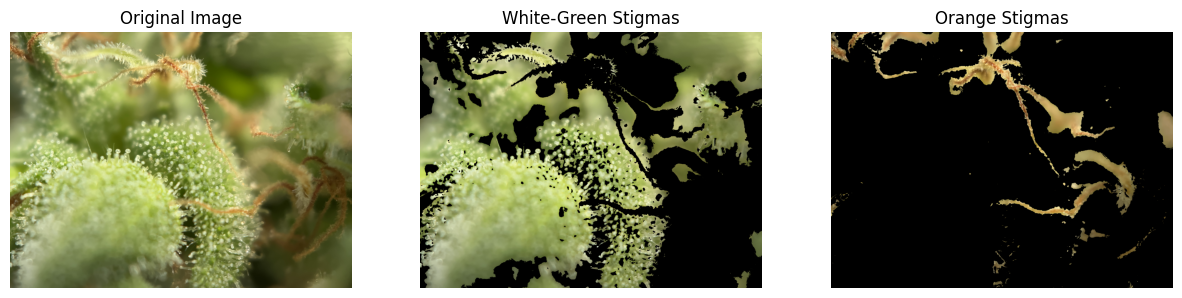

In [17]:

# Example usage
image_path = "/sise/shanigu-group/etaylor/assessing_cannabis_exp/images/day_9_2024_06_27/greenhouse/269/IMG_8709.JPG"
extract_and_display_stigmas(image_path)

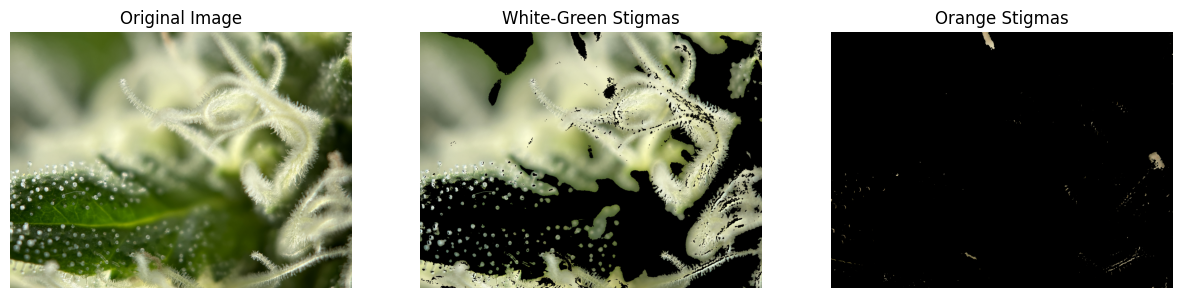

In [10]:
image_path = "/sise/shanigu-group/etaylor/assessing_cannabis_exp/images/stigmas_images/day_1/IMG_5133.JPG"
extract_and_display_stigmas(image_path)

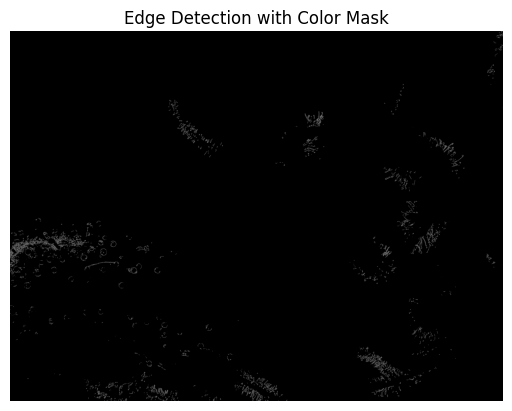

In [19]:
image_path = "/sise/shanigu-group/etaylor/assessing_cannabis_exp/images/stigmas_images/day_1/IMG_5133.JPG"
edge_detection_with_color(image_path)

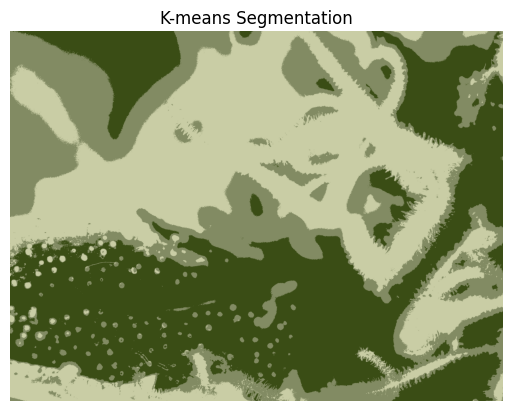

In [21]:
segment_using_kmeans(image_path)

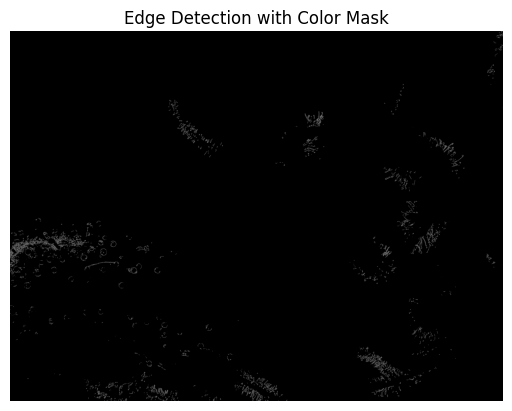

In [23]:
# Example usage
edge_detection_with_color(image_path)

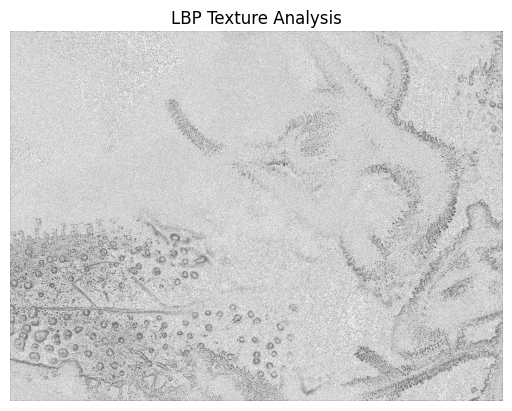

In [24]:


# Example usage
lbp_segmentation(image_path)


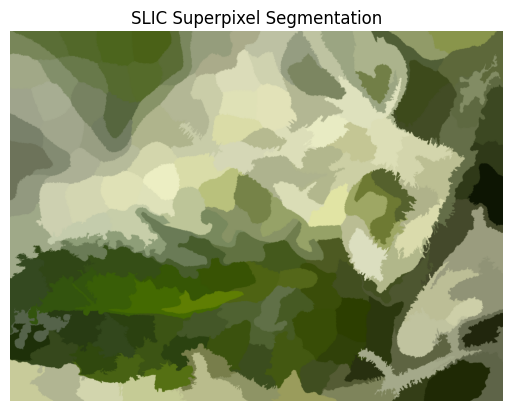

In [25]:


# Example usage
slic_superpixel_segmentation(image_path)


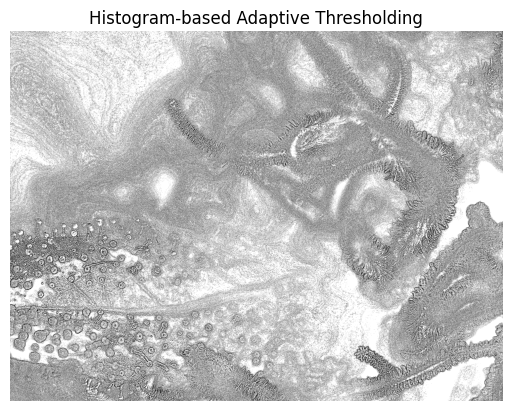

In [26]:


# Example usage
histogram_thresholding(image_path)


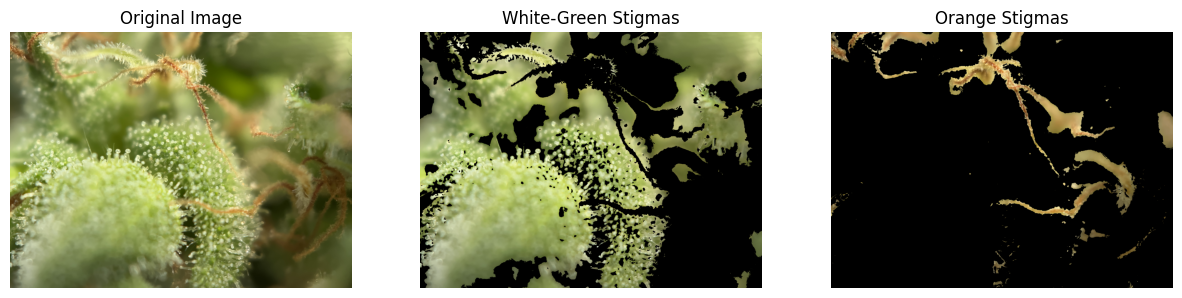

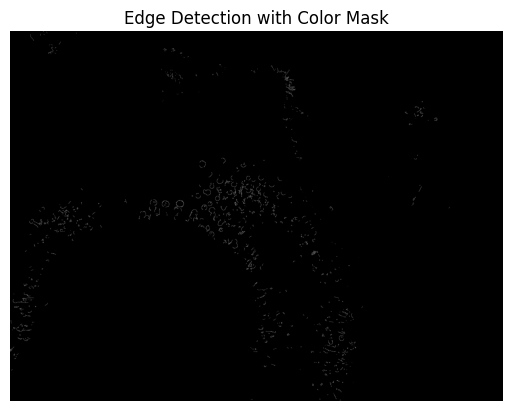

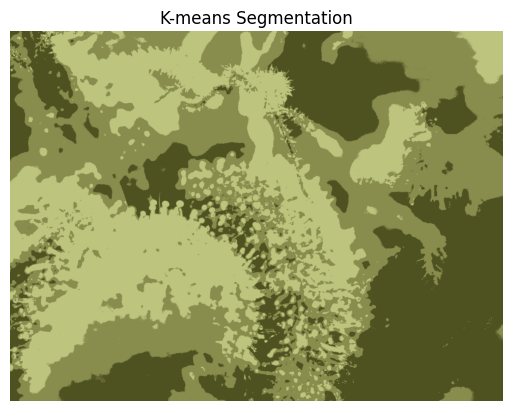

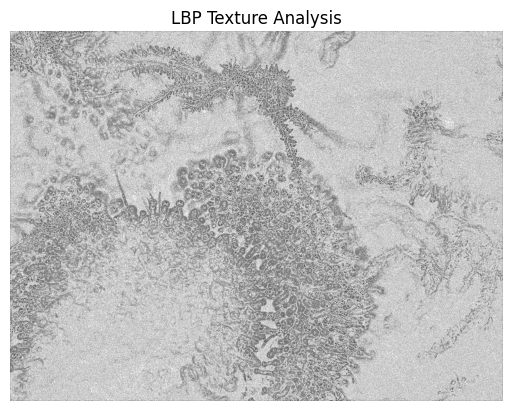

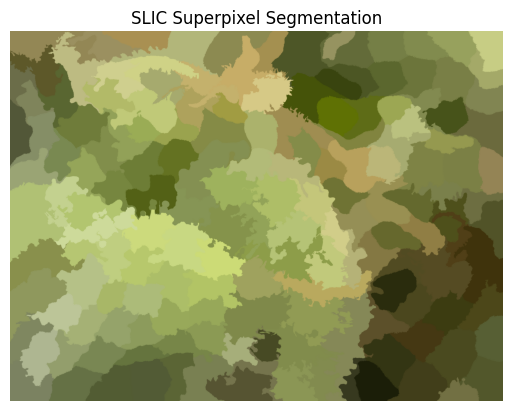

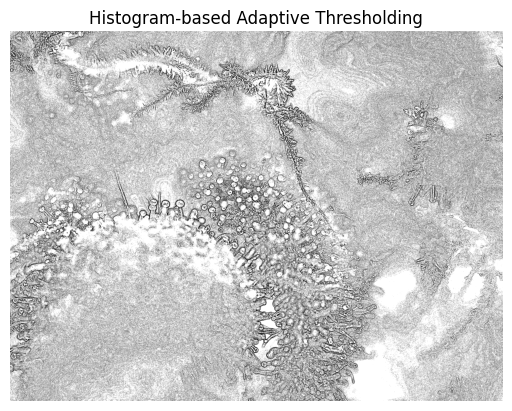

In [28]:
image_path = "/sise/shanigu-group/etaylor/assessing_cannabis_exp/images/day_9_2024_06_27/greenhouse/269/IMG_8709.JPG"

# try all methods of segmentation
extract_and_display_stigmas(image_path)
edge_detection_with_color(image_path)
segment_using_kmeans(image_path)
lbp_segmentation(image_path)
slic_superpixel_segmentation(image_path)
histogram_thresholding(image_path)